In [1]:
import pandas
import glob
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from make_counts_table_kellis import read_counts, get_counts
%matplotlib inline

cells = ["HepG2", "K562"]
designs = ["ScaleUpDesign1", "ScaleUpDesign2"]
promoters = ["minP", "SV40P"]

In [2]:
def act(rna, dna, thresh = 20):
    rna, dna = rna[dna > thresh], dna[dna > thresh]
    return (np.log(rna + 1) - np.log(dna + 1)
            - np.log(sum(rna + 1)) + np.log(sum(dna + 1)))

# Read in Data

In [3]:
names = {}
seqs = {}
rna1 = {}
rna2 = {}
dna  = {}
for design in designs:
    names[design] = None
    seqs[design]  = None
    rna1[design] = []
    rna2[design] = []
    dna[design] = []
    header = ['Name']
    for cell in cells:
        for promoter in promoters:
            header += ["{}-{}".format(cell, promoter)]
            (names[design], seqs[design],
             r1, r2, d) = get_counts(cell, promoter, design,
                                     names[design], seqs[design])
            rna1[design] += [r1]
            rna2[design] += [r2]
            dna[design] += [d]
    rna1[design] = np.vstack(rna1[design]).T
    rna2[design] = np.vstack(rna2[design]).T
    dna[design] = np.vstack(dna[design]).T
    assert rna1[design].shape == rna2[design].shape == dna[design].shape

['../data/kellis/raw/GSM1831757_HepG2_ScaleUpDesign1_minP_mRNA_Rep1.counts.txt.gz'] ['../data/kellis/raw/GSM1831758_HepG2_ScaleUpDesign1_minP_mRNA_Rep2.counts.txt.gz'] ['../data/kellis/raw/GSM1831773_ScaleUpDesign1_minP_Plasmid.counts.txt.gz']
['../data/kellis/raw/GSM1831759_HepG2_ScaleUpDesign1_SV40P_mRNA_Rep1.counts.txt.gz'] ['../data/kellis/raw/GSM1831760_HepG2_ScaleUpDesign1_SV40P_mRNA_Rep2.counts.txt.gz'] ['../data/kellis/raw/GSM1831774_ScaleUpDesign1_SV40P_Plasmid.counts.txt.gz']
['../data/kellis/raw/GSM1831765_K562_ScaleUpDesign1_minP_mRNA_Rep1.counts.txt.gz'] ['../data/kellis/raw/GSM1831766_K562_ScaleUpDesign1_minP_mRNA_Rep2.counts.txt.gz'] ['../data/kellis/raw/GSM1831773_ScaleUpDesign1_minP_Plasmid.counts.txt.gz']
['../data/kellis/raw/GSM1831767_K562_ScaleUpDesign1_SV40P_mRNA_Rep1.counts.txt.gz'] ['../data/kellis/raw/GSM1831768_K562_ScaleUpDesign1_SV40P_mRNA_Rep2.counts.txt.gz'] ['../data/kellis/raw/GSM1831774_ScaleUpDesign1_SV40P_Plasmid.counts.txt.gz']
['../data/kellis/raw/G

# Load DESeq2

In [5]:
lfc = []
lfc_se = []
pvals = []
with open('../data/kellis/de/ScaleUpDesign1-MINP-HepG2.deseq') as fp:
    print fp.readline()
    for line in fp:
        name, mean, lf2c, lfc_mle, lf2c_se, stat, pval, padj = line.strip().split('\t')
        lfc    += [float(0 if lf2c == 'NA' else lf2c)]
        lfc_se += [float(0 if lf2c_se == 'NA' else lf2c_se)]
        pvals  += [float(1 if pval == 'NA' else pval)]
lfc = np.array(lfc)
lfc_se = np.array(lfc_se)
pvals = np.array(pvals)

"baseMean"	"log2FoldChange"	"lfcMLE"	"lfcSE"	"stat"	"pvalue"	"padj"



4846
SpearmanrResult(correlation=0.37691900488708496, pvalue=0.0)


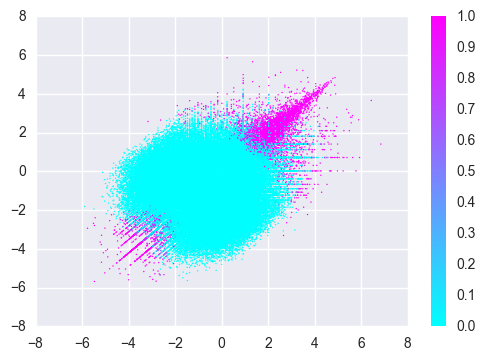

In [6]:
design = 'ScaleUpDesign1'
r1, r2 = rna1[design][:, 0], rna2[design][:, 0]
d = dna[design][:, 0]

a1, a2 = act(r1, d, -1), act(r2, d, -1)
sc = plt.scatter(a1, a2,
                 c = pvals < .1,
                 cmap = 'cool',
                 s = 1, lw = 0)
print sum(pvals < .05)
print stats.spearmanr(a1, a2)

plt.colorbar(sc)
plt.show()

4846
SpearmanrResult(correlation=0.37691900488708496, pvalue=0.0)


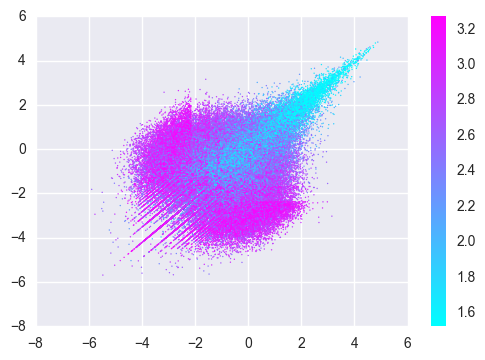

In [7]:
design = 'ScaleUpDesign1'
r1, r2 = rna1[design][:, 0], rna2[design][:, 0]
d = dna[design][:, 0]

a1, a2 = act(r1, d, -1), act(r2, d, -1)
sc = plt.scatter(a1[d > 20], a2[d > 20],
                 c = lfc_se[d > 20]**2,
                 cmap = 'cool',
                 s = 1, lw = 0)
print sum(pvals < .05)
print stats.spearmanr(a1, a2)

plt.colorbar(sc)
plt.show()

# Weighted Regression

In [8]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
design = 'ScaleUpDesign1'
BASES = ['A', 'C', 'G', 'T']
r1, r2 = rna1[design][:, 0], rna2[design][:, 0]
d = dna[design][:, 0]
def kmerize(X, k):
    bases = ['00', '01', '10', '11']
    counts = []
    for seq in X:
        binary_seq = ''.join(map(lambda x: bases[x], seq))
        count = np.zeros((4**k,), dtype = int)
        for i in range(0, len(seq) - k + 1):
            count[int(binary_seq[i*2:(i+k)*2], 2)] += 1
        counts += [count]
    return np.vstack(counts)

def seqs_to_matrix(seqs):
    return np.vstack([map(lambda x: BASES.index(x), seq)
                     for seq in seqs])

def get_X(idx, k):
    return kmerize(seqs_to_matrix(seqs[design][idx]), k)

def get_y(idx):
    a1, a2 = act(r1, d, -1), act(r2, d, -1)
    return scale((a1+a2)[idx]/2.0)

def evaluate(true, pred):
    print stats.spearmanr(true, pred)
    print stats.pearsonr(true, pred)
    plt.scatter(true, pred, s= 1, lw = 0)
    plt.show()

In [ ]:
X = get_X(d > 20, 6)
y = get_y(d > 20)
y_lfc = lfc[d > 20]
w = 1 / lfc_se[d > 20]**2

(X_train, X_test,
 y_train, y_test,
 y_shrunk_train, y_shrunk_test,
 w_train, w_test) = train_test_split(X, y, y_lfc, w,
                                     test_size = 0.2,
                                     random_state = 42)

normal_model   = SGDRegressor(penalty = 'l1',
                              n_iter = 30
                             ).fit(X_train, y_train)
shrunken_model = SGDRegressor(penalty = 'l1',
                              n_iter = 30
                             ).fit(X_train, y_shrunk_train)
weighted_model = SGDRegressor(penalty = 'l1',
                              n_iter = 30
                             ).fit(X_train, y_train,
                                   sample_weight = w_train)

In [ ]:
evaluate(y_test, normal_model.predict(X_test))
evaluate(y_test, shrunken_model.predict(X_test))
evaluate(y_test, weighted_model.predict(X_test))

In [ ]:
evaluate(y_shrunk_test, normal_model.predict(X_test))
evaluate(y_shrunk_test, shrunken_model.predict(X_test))
evaluate(y_shrunk_test, weighted_model.predict(X_test))

In [ ]:
plt.hist(w, bins = 100)
plt.show()

# Predict statistically significant changes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

BASES = ['A', 'C', 'G', 'T']

def kmerize(X, k):
    bases = ['00', '01', '10', '11']
    counts = []
    for seq in X:
        binary_seq = ''.join(map(lambda x: bases[x], seq))
        count = np.zeros((4**k,), dtype = int)
        for i in range(0, len(seq) - k + 1):
            count[int(binary_seq[i*2:(i+k)*2], 2)] += 1
        counts += [count]
    return np.vstack(counts)

def seqs_to_matrix(seqs):
    return np.vstack([map(lambda x: BASES.index(x), seq)
                     for seq in seqs])

In [ ]:
design = 'ScaleUpDesign1'
idx = d > 20

X = kmerize(seqs_to_matrix(seqs[design][idx]), 1)
y = (pvals < .05)[idx]

d_X_train, d_X_test, d_y_train, dummy_y_test = train_test_split(X, y,
                                     test_size = 0.2,
                                     random_state = 42)

dummy_model = LogisticRegression().fit(d_X_train, d_y_train)
dummy_pred = dummy_model.predict_proba(d_X_test)

In [ ]:
design = 'ScaleUpDesign1'
idx = d > 20

X = kmerize(seqs_to_matrix(seqs[design][idx]), 6)
y = (pvals < .05)[idx]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                     test_size = 0.2,
                                     random_state = 42)

model = LogisticRegression().fit(X_train, y_train)
pred = model.predict_proba(X_test)

In [ ]:
print metrics.roc_auc_score(y_test, pred[:, 1])
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred[:, 0])
plt.plot(tpr, fpr)
print metrics.roc_auc_score(dummy_y_test, dummy_pred[:, 1])
fpr, tpr, thresholds = metrics.roc_curve(dummy_y_test, dummy_pred[:, 0])
plt.plot(tpr, fpr)
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.precision_recall_curve(y_test, pred[:, 1])
plt.plot(tpr, fpr)
fpr, tpr, thresholds = metrics.precision_recall_curve(dummy_y_test, dummy_pred[:, 1])
plt.plot(tpr, fpr)
plt.show()